<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Numerical methods: 11. Finite differences 
## Advection equation in 1D
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

----
In this notebook, we solve a simple **transient advection equation** in one dimension,
using different numerical methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The general advection-diffusion-reacton equation from the last part reads:
$$\fbox{$
\frac{\partial c}{\partial t}
= - v \frac{dc}{dx}
+ D \frac{d^2c}{dx^2}
+ R
$}$$

----
## Advection

We start defining the transient advection equation. We describe a quantity $c(x,t)$ in an incompressible fluid,
which changes its position only through advection of the particle quantity:
$$
c(x,t+\Delta t) = c(x-v \Delta t,t)
$$
with
$x$ [m] the position,
$t$ [s] time,
$v$ [m/s] the velocity, and
$\Delta t$ [s] the time increment.

We expand both sides of the equation into a **Taylor series** til the first-order term:
$$
c(x,t) + \Delta t \frac{\partial c(x,t)}{\partial t}
\simeq
c(x,t) - v \Delta t \frac{\partial c(x,t)}{\partial x}
$$
which can be recasted into the `transient advection equation`:
$$
\fbox{$
\frac{\partial c(x,t)}{\partial t} + v \frac{\partial c(x,t)}{\partial x} = 0
$}
$$

The transient advection equation is a **hyperbolic partial differential equation**, which has a unique
solution for the **initial condition**:
$$
c(x,t=0) = c_0(x,0)
$$

----
## Gaussian function

We define the `Gaussian` function with mean $\mu$ and standard deviation $\sigma$:
$$
c(x,t) = e^{-\frac{(x-vt-\mu)^2}{\sigma^2}}
$$
which is a solution of the transient advection equation.

In [2]:
def gaussian(x,v=0.5,t=0.,mu=2.,sigma=1.):
    f = np.exp(-(x-v*t-mu)**2/(sigma)**2)
    return f

In [3]:
xstep = 101
x,dx = np.linspace(0,10,xstep,retstep=True)   # m

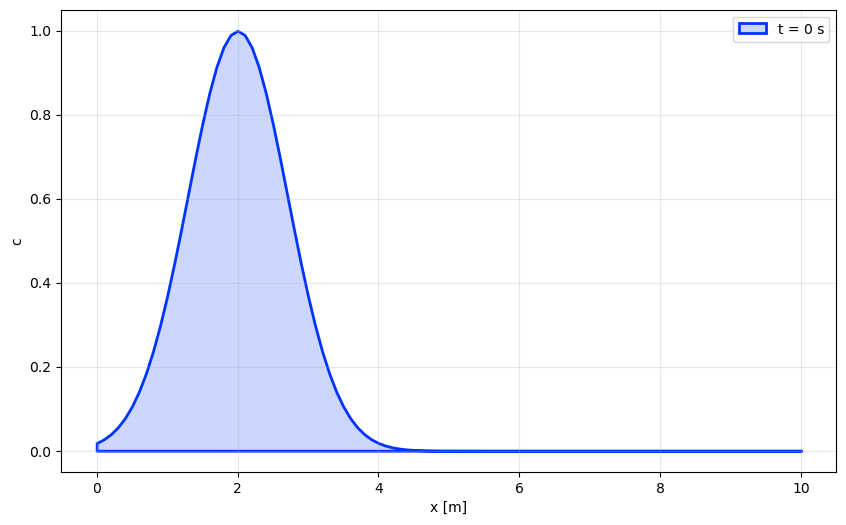

In [4]:
u0 = gaussian(x)

plt.figure(figsize=(10,6))
plt.xlabel('x [m]')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.fill_between(x,u0,0,label='t = 0 s',linewidth=2,edgecolor=(0,0.2,1,1.0), facecolor=(0,0.2,1,.2))
plt.legend()

----
## Numerical solution methods

Next, we derive several numerical methods, which can be used to solve the transient advection equation.
We first need to assign the temporal and spatial time steps, $\Delta t$ [s] and $\Delta x$ [m], 
and the velocity $c$ [m/s]:

Thus we have discretised both spatial and temporal variables:
$$
\begin{array}{rcl}
t_n &=& t_0 + n \Delta t, \quad n=0,N \\
x_i &=& x_0 + i \Delta x, \quad i=0,I
\end{array}
$$

The `Courant number`, defined as
$$
Co = \frac{v \Delta t}{\Delta x}
$$
defines the stability of the numerical solutions. Explicit solutions are stable
for $Co <1$.

We solve for the time increment:
$$
\Delta t < \frac{\Delta x}{v}
$$

In [5]:
v = 1.0 # m/s
dt = dx/v
print ('Courant time step: ',dt)
dt = 0.2*dt
print ('Courant time step with savety margin: ',dt)

Courant time step:  0.1
Courant time step with savety margin:  0.020000000000000004


In [6]:
time = np.arange(0,8,dt)

----
## FTCS scheme (forward time centered space)

Our first scheme is called `FTCS`, forward time, centered space, thus the derivatives in the
transient advection equations are replaced by **forward differences in time** and 
**central differences is space**:
$$
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t}
=
-v \frac{c_{i+1}^{n}-c_{i-1}^{n}}{2 \Delta x}
$$
or solved for the next time step
$$
c_{i}^{n+1}
=
c_{i}^{n} -\frac{v \Delta t}{2 \Delta x} \left( c_{i+1}^{n}-c_{i-1}^{n} \right)
$$

<img src="images/PDE_FTCS.jpg" style="height:5cm;">

We implement the FTCS method:

In [7]:
nt = time.shape[0]
nx = x.shape[0]
U = np.zeros(nt*nx).reshape(nx,nt)
u = np.zeros(nx)
print(U.shape)
# initial step
U[:,0] = gaussian(x)
# time iteration
for n in range(1,time.shape[0]):
    uold = U[:,n-1]
    for i in range(u.shape[0]):
        u[i] = uold[i] - v*dt/2/dx * (np.roll(uold,-1)[i] - np.roll(uold,+1)[i])
    U[:,n] = u

(101, 400)


In [8]:
aa = np.arange(0,10)
print(aa)
print(np.roll(aa,-1))
print(np.roll(aa,+1))
print(aa[5],np.roll(aa,-1)[5],np.roll(aa,1)[5])

[0 1 2 3 4 5 6 7 8 9]
[1 2 3 4 5 6 7 8 9 0]
[9 0 1 2 3 4 5 6 7 8]
5 6 4


[2.] [1.]
[4.] [1.04056319]
[5.9] [1.08360687]
[8.1] [1.2725598]


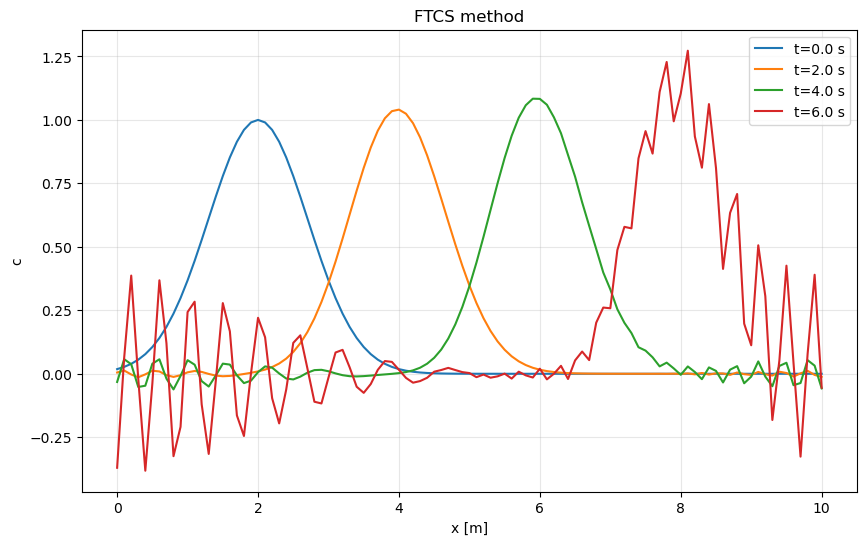

In [9]:
plt.figure(figsize=(10,6))
plt.xlabel('x [m]')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.title('FTCS method')
for j in range(0,U.shape[1],100):
    print(x[np.where(U[:,j] == np.amax(U[:,j]))],U[:,j][np.where(U[:,j] == np.amax(U[:,j]))])
    plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
plt.legend()

----
## Upwind scheme

Our second scheme is from the group of `upwind scheme`, which promote a solution skewed in the direction
of the advective flow, thus on $c$. We keep the **forward operator in time**, and implement either
a **backward** or **forward operator in space**, depending of the sign of $c$:
$$
\begin{array}{rcl}
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t} &=& -v \frac{c_{i}^{n}-c_{i-1}^{n}}{\Delta x}, \quad c>0 \\
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t} &=& -v \frac{c_{i+1}^{n}-c_{i}^{n}}{\Delta x}, \quad c<0 
\end{array}
$$
or solved for the next time step
$$
\begin{array}{rcl}
c_{i}^{n+1} &=& c_{i}^{n}-\frac{v \Delta t}{\Delta x} \left( c_{i}^{n}-c_{i-1}^{n} \right), \quad c>0 \\
c_{i}^{n+1} &=& c_{i}^{n}-\frac{v \Delta t}{\Delta x} \left( c_{i+1}^{n}-c_{i}^{n} \right), \quad c<0 
\end{array}
$$

<img src="images/PDE_upwind.jpg" style="height:5cm;">

We implement the upwind method:

In [10]:
nt = time.shape[0]
nx = x.shape[0]
U = np.zeros(nt*nx).reshape(nx,nt)
u = np.zeros(nx)
print(U.shape)
# initial values
U[:,0] = gaussian(x)
# time iteration
for n in range(1,time.shape[0]):
    uold = U[:,n-1]
    for i in range(u.shape[0]):
        u[i] = uold[i] - v*dt/dx*(uold[i]-uold[i-1])
    U[:,n] = u

(101, 400)


[2.] [1.]
[4.] [0.8703463]
[6.] [0.78077614]
[8.] [0.71415673]


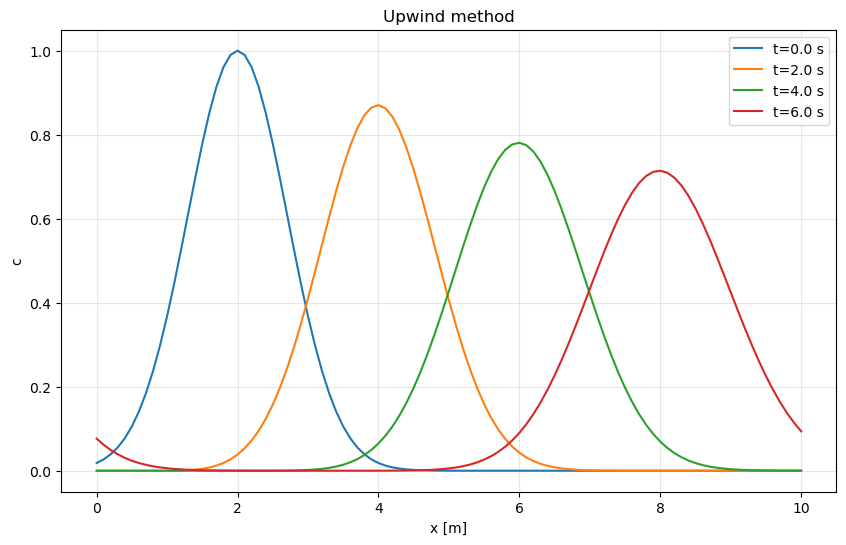

In [11]:
 plt.figure(figsize=(10,6))
plt.xlabel('x [m]')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.title('Upwind method')
for j in range(0,U.shape[1],100):
    print(x[np.where(U[:,j] == np.amax(U[:,j]))],U[:,j][np.where(U[:,j] == np.amax(U[:,j]))])
    plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
plt.legend()

----
## Lax method

Our third scheme is called `Lax method`, it is derived from the FTCS method, but the term
$u_i^n$ is replaced by the average of its two neighbors:
$$
c_{i}^{n+1}
=
\frac{1}{2} \left( c_{i+1}^{n} + c_{i-1}^{n} \right) 
-\frac{v \Delta t}{2 \Delta x} \left( c_{i+1}^{n}-c_{i-1}^{n} \right)
$$

<img src="images/PDE_FTCS.jpg" style="height:5cm;">

We implement the LAX method:

In [12]:
nt = time.shape[0]
nx = x.shape[0]
U = np.zeros(nt*nx).reshape(nx,nt)
u = np.zeros(nx)
print(U.shape)
# initial values
U[:,0] = gaussian(x)
# time iteration
for n in range(1,time.shape[0]):
    uold = U[:,n-1]
    for i in range(u.shape[0]-1):
        u[i] = (uold[i+1]+uold[i-1])/2. - v*dt/2/dx*(uold[i+1]-uold[i-1])
    U[:,n] = u

(101, 400)


[2.] [1.]
[4.] [0.58434101]
[6.] [0.4534185]
[8.] [0.383299]


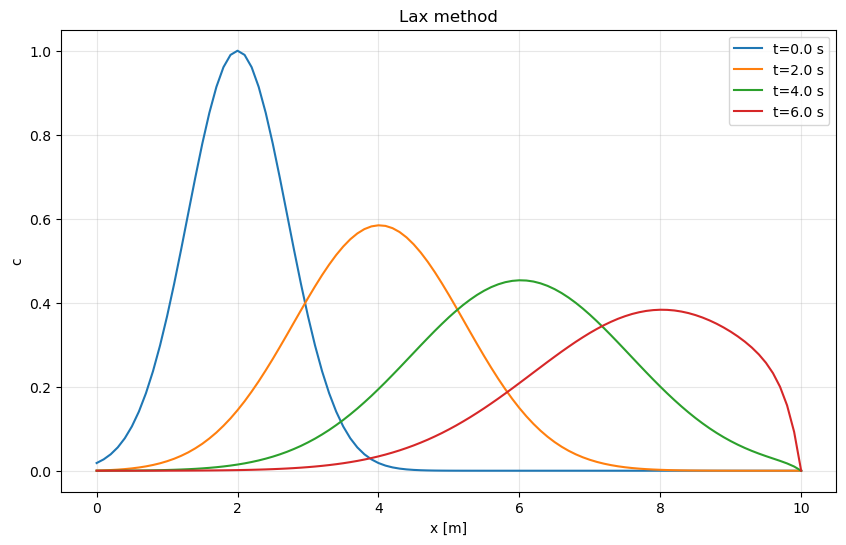

In [13]:
 plt.figure(figsize=(10,6))
plt.xlabel('x [m]')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.title('Lax method')
for j in range(0,U.shape[1],100):
    print(x[np.where(U[:,j] == np.amax(U[:,j]))],U[:,j][np.where(U[:,j] == np.amax(U[:,j]))])
    plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
plt.legend()

----
## Lax-Wendroff method

Our fourth scheme is called `Lax-Wendroff method`, it is a **two-step** procedure:
$$
\begin{array}{rcl}
c_{i-\frac{1}{2}}^{n+\frac{1}{2}} &=& \frac{1}{2} \left( c_{i-1}^{n} + c_{i}^{n} \right)
- \frac{v \Delta t}{2 \Delta x} \left( c_{i}^{n}-c_{i-1}^{n} \right) \\
c_{i+\frac{1}{2}}^{n+\frac{1}{2}} &=& \frac{1}{2} \left( c_{i}^{n} + c_{i+1}^{n} \right)
- \frac{v \Delta t}{2 \Delta x} \left( c_{i+1}^{n}-c_{i}^{n} \right) \\
c_{i}^{n+1} &=& u_{i}^{n} - \frac{v \Delta t}{\Delta x}
\left( c_{i+\frac{1}{2}}^{n+\frac{1}{2}} - c_{i-\frac{1}{2}}^{n+\frac{1}{2}}\right)
\end{array}
$$

<img src="images/PDE_LAX_WENDROFF.jpg" style="height:5cm;">

We implement the LAX-WENDROFF method:

In [14]:
nt = time.shape[0]
nx = x.shape[0]
U = np.zeros(nt*nx).reshape(nx,nt)
u = np.zeros(nx)
print(U.shape)
# initial values
U[:,0] = gaussian(x)
# time iteration
for n in range(1,time.shape[0]):
    uold = U[:,n-1]
    for i in range(1,u.shape[0]-1):
        uleft  = (uold[i-1]+uold[i])/2. - v*dt/2/dx*(uold[i]-uold[i-1])
        uright = (uold[i]+uold[i+1])/2. - v*dt/2/dx*(uold[i+1]-uold[i])
        u[i]   = uold[i] - v*dt/dx*(uright - uleft)
    U[:,n] = u

(101, 400)


[2.] [1.]
[4.] [0.99884079]
[6.] [0.99655218]
[7.9] [0.99440269]


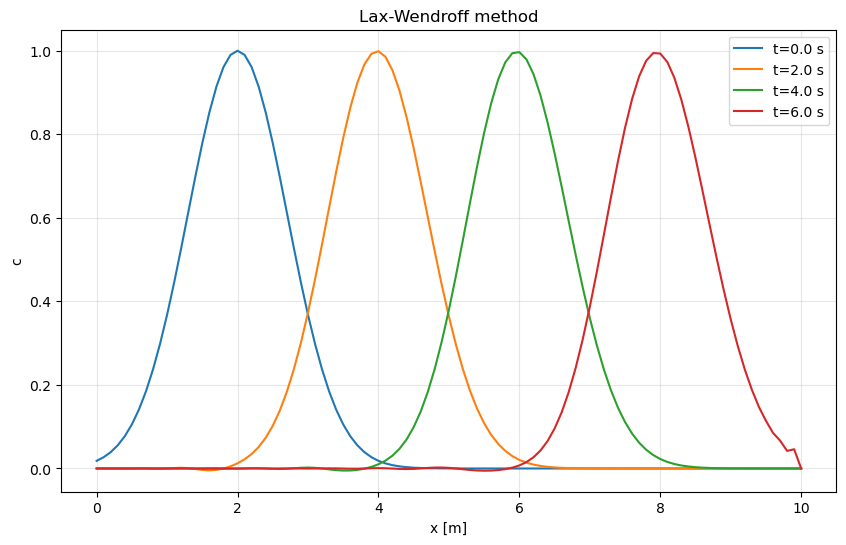

In [15]:
 plt.figure(figsize=(10,6))
plt.xlabel('x [m]')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.title('Lax-Wendroff method')
for j in range(0,U.shape[1],100):
    print(x[np.where(U[:,j] == np.amax(U[:,j]))],U[:,j][np.where(U[:,j] == np.amax(U[:,j]))])
    plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
plt.legend()

... done

... [or explain](Dynamics_lab03_advection1DFails_noshow.ipynb)